In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

In [2]:
# Loading data from source 
df = pd.read_csv(r"C:\AI Pwskill\Sentiment Analysis\data\sentiment500k.csv")

In [3]:
df.head(5)

,Text,Language,Label
0,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
1,Rwanda is set to host the headquarters of Unit...,en,positive
2,It sucks for me since I'm focused on the natur...,en,negative
3,@en_font Treballar a l’obra a partir dels 19 a...,ca,negative
4,Social Security. Constant political crises dis...,en,negative


# Data cleaning

---

In [4]:
# Checking for duplicate instances
print(f"There are {df.duplicated().sum()} duplicate instaces")

There are 2537 duplicate instaces


In [5]:
# droping duplicate rows
df.drop_duplicates(inplace=True, ignore_index=True)
print(f"There are {df.duplicated().sum()} duplicate instaces")

There are 0 duplicate instaces


In [6]:
# Checking for null values
df.isna().sum()

Text         0
Language    18
Label        0
dtype: int64

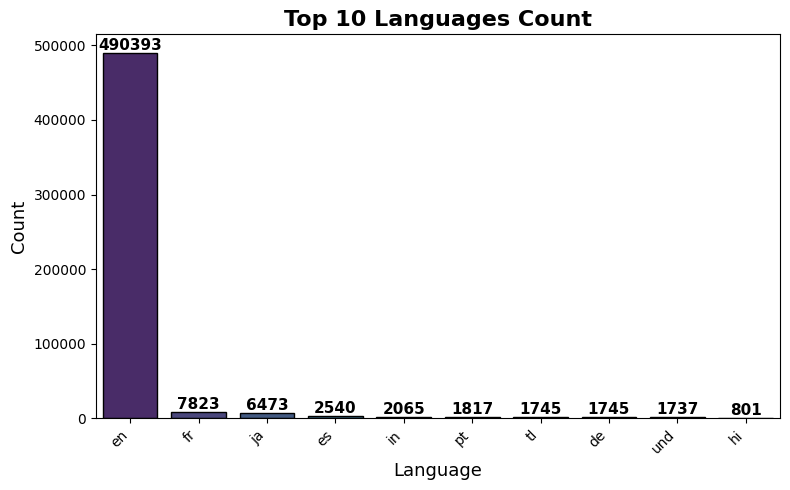

In [7]:
# Top 10 most frequent languages
top10_langs = df['Language'].value_counts().head(10).index

# Filter dataframe to only include those top 10
df_top10 = df[df['Language'].isin(top10_langs)]

# Create the count plot
plt.figure(figsize=(8,5))
ax = sns.countplot(x='Language', data=df_top10, palette='viridis', edgecolor='black',
                   order=top10_langs)  # ensures bars appear in top10 order

# Add counts on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}',
                (p.get_x() + p.get_width()/2, count),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='black')

# Titles and labels
plt.title('Top 10 Languages Count', fontsize=16, fontweight='bold')
plt.xlabel('Language', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

During the exploratory data analysis, I examined the ‘Language’ column and found a total of 71 unique language codes, indicating considerable linguistic diversity in the dataset. However, the distribution is highly skewed toward English (‘en’), which accounts for 492,662 records — by far the most dominant language. So I will impute the Language null values with 'en' i.e mode

Since English is the predominant language in our dataset—accounting for more than 90% of all entries—we will focus our model training exclusively on English-language data. This approach helps ensure consistency in text processing and model performance, while minimizing potential issues related to multilingual variability and translation errors.

In [8]:
# Keeping only english 
df = df[df['Language']=='en']

# If all language are english we can drop the language feature
df.drop('Language', axis=1, inplace=True)

In [9]:
# Mapping negative -> 0 and positive -> 1
df['Label'] = df['Label'].map({'negative': 0, 'positive': 1})

In [10]:
df.head(5)

,Text,Label
1,Rwanda is set to host the headquarters of Unit...,1
2,It sucks for me since I'm focused on the natur...,0
4,Social Security. Constant political crises dis...,0
5,@FilmThePoliceLA A broken rib can puncture a l...,0
6,@jacobringenwald @aKeithWatts @CountDankulaTV ...,0


# Text Preprocessing

---

In [11]:
import contractions
import unicodedata
import spacy
import nltk
import string
import re
import emoji

### Lower Case

In [12]:
# Lower casing the text
df['preprocessed_text'] = df['Text'].str.lower()

### Removing mentions on users

Removing mentions to other users because it doesnt provide any meaningful context to our problem statement.

In [13]:
df['preprocessed_text'] = df['preprocessed_text'].str.replace(r'@\w+', '', regex=True)

### Removing links

During the exploratory analysis of our dataset, we observed that many text entries contain URLs (e.g., https://t.co/...). These links point to external content but do not carry any intrinsic sentiment information. Since our primary goal is to analyze the sentiment expressed in the text, these URLs are irrelevant and could introduce noise in the model. Therefore, we will remove them from the dataset to ensure cleaner, more meaningful text for sentiment analysis.

In [14]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# Apply the function to each text entry
df['preprocessed_text'] = df['preprocessed_text'].apply(remove_urls)

### Expanding Contractions

In [15]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: contractions.fix(x))

### Removing Accents/Diacritics

In [16]:
def remove_accents_diacritics(text):
    """
    Normalize unicode text and remove accents/diacritics.
    Example: 'café' → 'cafe'
    """
    # Normalize to 'NFKD' form (decomposes accents)
    text = unicodedata.normalize('NFKD', text)
    # Keep only base characters (ignore diacritics)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    return text

df['preprocessed_text'] = df['preprocessed_text'].apply(remove_accents_diacritics)

### De-emojify the emojies into respective text

In [17]:
# Convert emojis to text descriptions
def convert_emojis(text):
    return emoji.demojize(text)

df['preprocessed_text'] = df['preprocessed_text'].apply(convert_emojis)

### Removing numbers and punctuation

In [18]:
# Remove punctuation and numbers
def remove_punct_numbers(text):
    return re.sub(r'[^a-z\s]', '', text)

# Applying function to the 'Text' column
df['preprocessed_text'] = df['preprocessed_text'].apply(remove_punct_numbers)

### Converting Raw text into Tokens

In [19]:
from nltk.tokenize import word_tokenize

df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: word_tokenize(x))

### Lemmetization

In [20]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

df['preprocessed_text'] = df['preprocessed_text'].apply(lemmatize_words)

In [21]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda tokens: " ".join(tokens))

In [22]:
df.head(5)

,Text,Label,preprocessed_text
1,Rwanda is set to host the headquarters of Unit...,1,rwanda is set to host the headquarters of unit...
2,It sucks for me since I'm focused on the natur...,0,it suck for me since i am focused on the natur...
4,Social Security. Constant political crises dis...,0,social security constant political crisis dist...
5,@FilmThePoliceLA A broken rib can puncture a l...,0,a broken rib can puncture a lung or lead to a ...
6,@jacobringenwald @aKeithWatts @CountDankulaTV ...,0,i agree it is a flawed response for a small an...


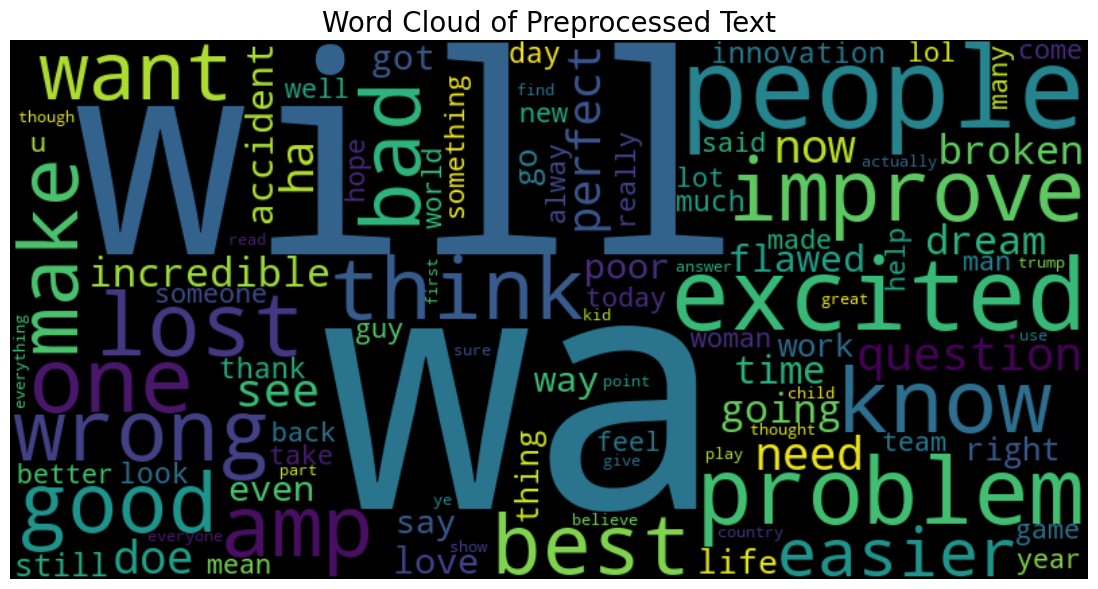

In [40]:
from wordcloud import WordCloud

preprocessed_text = " ".join(df['preprocessed_text'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='viridis',
    max_words=100
).generate(preprocessed_text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Preprocessed Text", fontsize=20)
plt.show()

# Text Vectorization

In [23]:
sentences = df['preprocessed_text'].tolist()

In [24]:
from keras.layers import TextVectorization, Embedding

vectorizer = TextVectorization(
    max_tokens=1193514,
    output_sequence_length=50,
    output_mode='int'
)

vectorizer.adapt(sentences)

### Downloading a pretrained Glove model on twitter dataset with 200 Dimensions

In [25]:
import gensim.downloader as api
print(api.info()['models'].keys())

glove_model = api.load('glove-twitter-200')

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [26]:
vocab = glove_model.index_to_key
embedding_dim = glove_model.vector_size
vocab_size = len(vocab) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i+1] = glove_model[word]

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True
)

### Train-test split

In [27]:
from sklearn.model_selection import train_test_split
X = df['preprocessed_text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
from keras.layers import LSTM, Dense, BatchNormalization, LayerNormalization, Dropout, Activation, Input
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(
    log_dir='Tensorboard/lstm'
)

In [29]:
model = Sequential(name='aryan_lstm')
model.add(vectorizer)
model.add(embedding_layer)
model.add(LSTM(units=64))
model.add(Activation('tanh'))
model.add(LayerNormalization())

model.add(Dense(32, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.8))

model.add(Dense(16, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "aryan_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   238,703,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,703,000 (910.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 238,703,000 (910.58 MB)

In [30]:
X_train = X_train.values

model.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, epochs=10, validation_split=0.2, callbacks=[tensorboard])

Epoch 1/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 60s 91ms/step - accuracy: 0.8799 - loss: 0.2734 - val_accuracy: 0.9738 - val_loss: 0.0735
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 64s 104ms/step - accuracy: 0.9724 - loss: 0.0850 - val_accuracy: 0.9791 - val_loss: 0.0626
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 62s 102ms/step - accuracy: 0.9758 - loss: 0.0724 - val_accuracy: 0.9756 - val_loss: 0.0667
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 69s 113ms/step - accuracy: 0.9773 - loss: 0.0653 - val_accuracy: 0.9821 - val_loss: 0.0523
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 60s 98ms/step - accuracy: 0.9787 - loss: 0.0602 - val_accuracy: 0.9824 - val_loss: 0.0493
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 71s 116ms/step - accuracy: 0.9798 - loss: 0.0565 - val_accuracy: 0.9806 - val_loss: 0.0523
Epoch 7/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 66s 108ms/step - accuracy: 0.9806 - loss: 0.0539 - val_accuracy: 0.9834 - val_loss: 0.0489
Epoch 8/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - accuracy: 0.9814 - loss: 0.0

In [31]:
model.evaluate(X_test.values, y_test)

3065/3065 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9834 - loss: 0.0468


[0.0468377061188221, 0.9833705425262451]

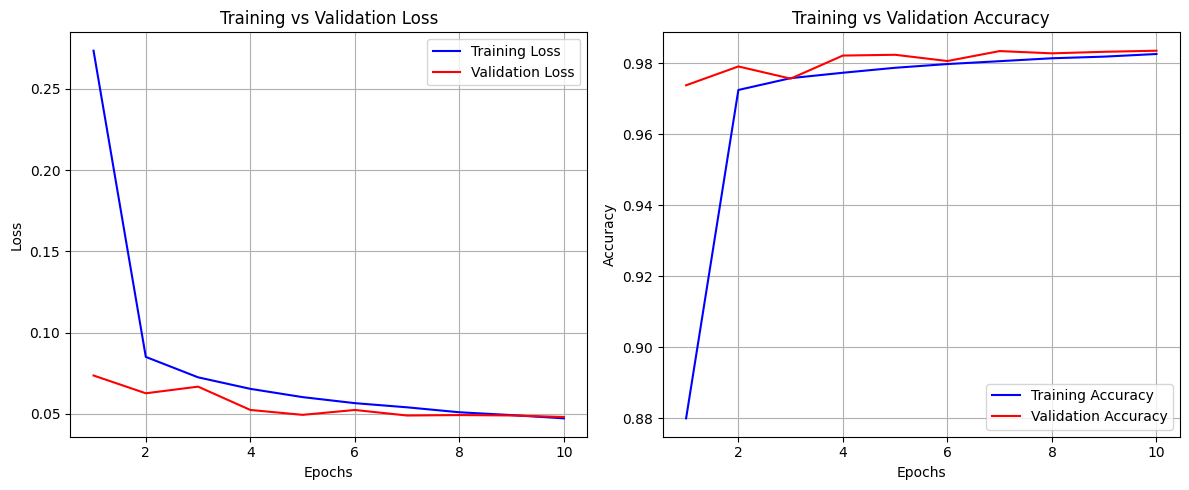

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# ---- Plot Loss ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ---- Plot Accuracy ----
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import roc_curve

# Step 1: Get predicted probabilities
y_proba = model.predict(X_test.values)

# Step 2: Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test.values, y_proba)

# Step 3: Compute Youden's J statistic
j_scores = tpr - fpr

# Step 4: Find the best threshold
best_index = j_scores.argmax()
best_threshold = thresholds[best_index]

print("Best Threshold:", best_threshold)
print("TPR:", tpr[best_index])
print("FPR:", fpr[best_index])

3065/3065 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step
Best Threshold: 0.6941687
TPR: 0.9773151909017059
FPR: 0.009664407543151989


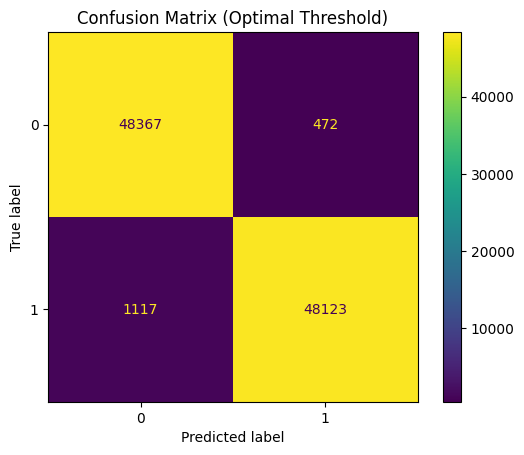

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use optimal threshold
y_pred_best = (y_proba >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Optimal Threshold)")
plt.show()


In [36]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)

print("\n--- Standard Metrics (best threshold) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


--- Standard Metrics (best threshold) ---
Accuracy: 0.9837987744573252
Precision: 0.9902870665706348
Recall: 0.9773151909017059
F1-score: 0.9837583686819645
ROC AUC: 0.9986990348882363


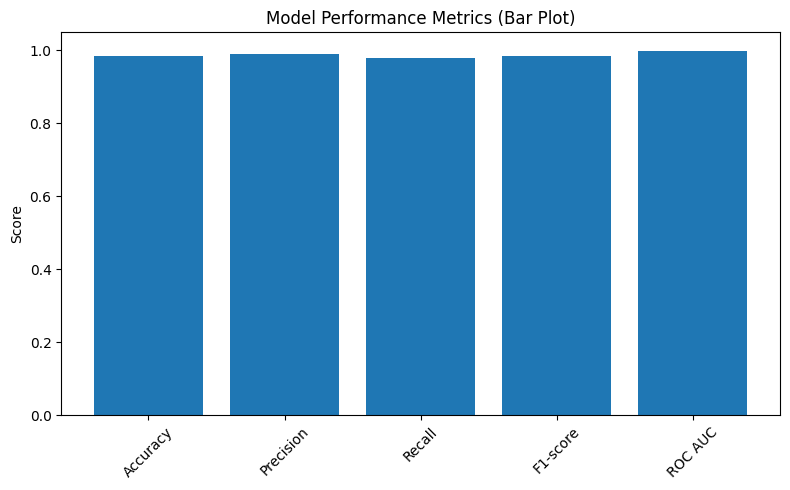

In [37]:
acc = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best)
rec = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
auc = roc_auc_score(y_test, y_proba)

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "ROC AUC": auc
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(list(metrics.keys()), list(metrics.values()))
plt.ylabel("Score")
plt.title("Model Performance Metrics (Bar Plot)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()